# Demo: pciSeq 
This is a example showing how to use pciSeq to cell type iss data

## Installation:

In [1]:
!pip install pciSeq==0.0.26

Other libraries needed for this notebook:

In [2]:
# !pip install -i https://test.pypi.org/simple/ pciSeq
# pip install '../dist/pciSeq-0.0.1-py3-none-any.whl'
import os
import pandas as pd
import numpy as np
import skimage.color
from scipy.sparse import coo_matrix
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import pciSeq
from pciSeq.src.cell_call import utils
from configparser import ConfigParser

/usr/local/lib/python3.6/dist-packages/pciSeq


## 1. Loading the data

The required inputs are: 
* Segmentation
* Spots
* Single cell data

### 1.1. The segmentation array
This should be a labelled array of coo_matrix datatype. The labels correspond to the objects (nuclei) that were detected during segmentation. A label of value = 0 denotes the background 

In [3]:
coo_file = utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/segmentation/label_image.coo.npz?raw=true')
coo = load_npz(coo_file)
print('The image has %d cells' % len(set(coo.data)))

The image has 3481 cells


Let's now plot the segmented cells:

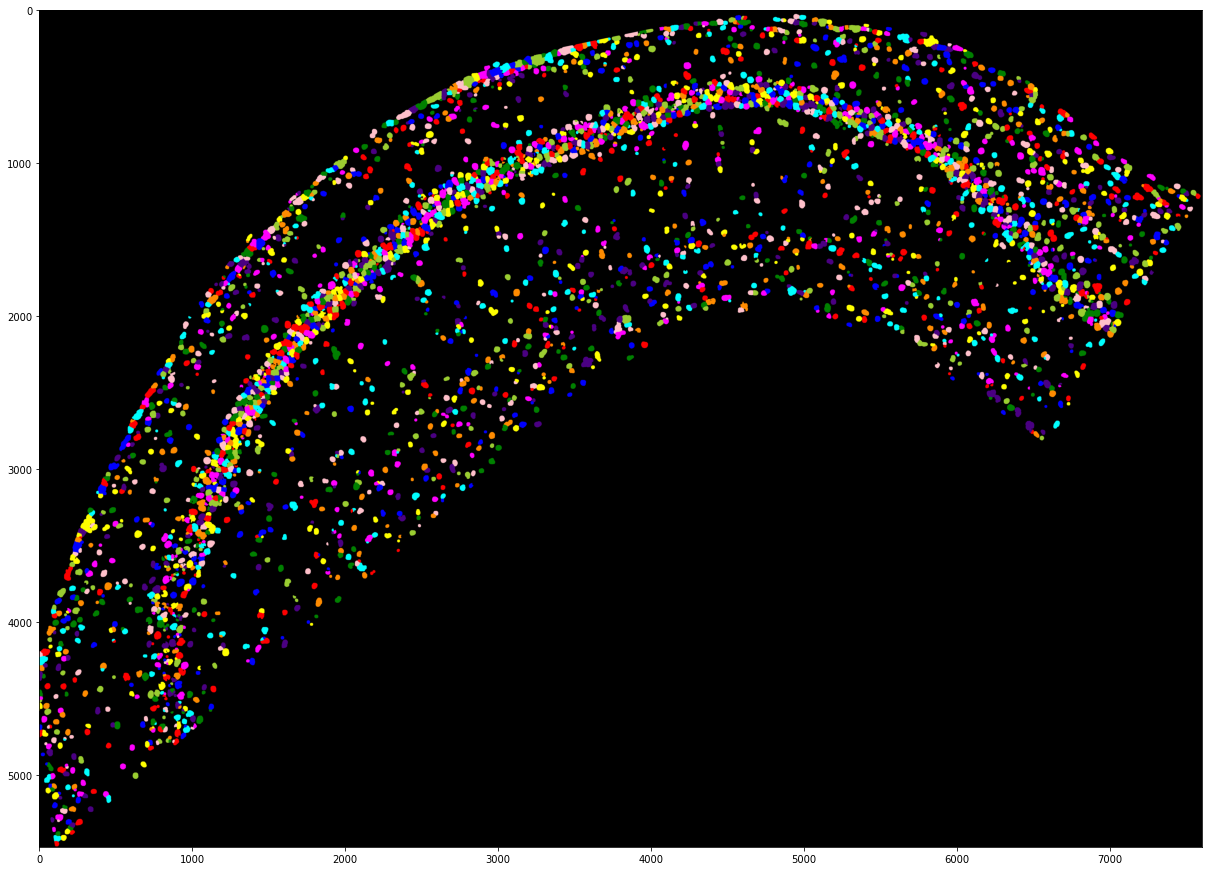

In [4]:
rgb_label_image = skimage.color.label2rgb(coo.toarray(), bg_label=0)
_dpi = 72
plt.figure(figsize=(1500/_dpi, 1500/_dpi), dpi=_dpi)
imgplot = plt.imshow(rgb_label_image)
plt.show()

### 1.2. The spots

The spots should be a dataframe with column names: 'Gene', 'x', 'y'. 

In [5]:
spots_file = utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/iss/spots.csv?raw=true')
iss_spots = pd.read_csv(spots_file)
iss_spots.head()

Gene    x     y
0  Cxcl14  110  5457
1    Plp1   -1  4735
2    Plp1   -1  4725
3     Id2   -1  4478
4   Enpp2   -1  4455

#### Caution! 
It is important to make sure that the spots and the segmentation array are not misaligned. If the orign of the ROI containing our spots is not at [0, 0] then the spot coords must be shifted and/or flipped in such a manner that they are inline with the segmentation data.

We can overlay the spots to the cells to quicly check whether this holds

In [6]:
my_dpi = 72
plt.figure(figsize=(1500/my_dpi, 1500/my_dpi), dpi=my_dpi)
imgplot = plt.imshow(rgb_label_image)
plt.scatter(iss_spots.x, iss_spots.y, s=1)
plt.show()

### 1.3. The single cell data

This is another dataframe with columns the cell classes and rows the genes. The expression data are UMI counts as they come from single cell sequencing.

In [7]:
sc_file = utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/scRNA/scRNAseq.csv.gz?raw=true')
scRNAseq = pd.read_csv(sc_file, header=None, index_col=0, compression='gzip', dtype=object)
scRNAseq = scRNAseq.rename(columns=scRNAseq.iloc[0], copy=False).iloc[1:]
scRNAseq = scRNAseq.astype(np.float).astype(np.uint32)

In [8]:
scRNAseq.head()

PC.CA1.1  PC.CA1.1  PC.CA1.1  ...  Sst.Nos1  Sst.Nos1  Sst.Nos1
0                                      ...                              
Xkr4            0         0         0  ...         0         0         0
Gm1992          0         0         0  ...         0         0         0
Gm37381         0         0         0  ...         0         0         0
Rp1             0         0         0  ...         0         0         0
Rp1             0         0         0  ...         0         0         0

[5 rows x 5712 columns]

## 2. Cell typing

We can now do the cell typing:

First load the hyperparameters

In [9]:
ini_file = utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/config.ini?raw=true')
cfg = ConfigParser()
cfg.read(ini_file)

['config.ini']

In [10]:
cellData, geneData = pciSeq.app(iss_spots, coo, scRNAseq, cfg)

2021-01-15 06:03:37,539:INFO:Preprocessing data
2021-01-15 06:03:37,541:INFO:Number of spots passed in: 72336
2021-01-15 06:03:38,233:INFO:Number of segmented cells 3481
2021-01-15 06:03:38,235:INFO:Segmentation array implies that image has width: 7602px and height: 5471px
2021-01-15 06:04:02,969:INFO:Start cell typing
2021-01-15 06:04:06,206:INFO:Iteration 0, mean prob change 1.000000
2021-01-15 06:04:08,552:INFO:Iteration 1, mean prob change 0.794103
2021-01-15 06:04:10,860:INFO:Iteration 2, mean prob change 0.465455
2021-01-15 06:04:13,174:INFO:Iteration 3, mean prob change 0.271387
2021-01-15 06:04:15,483:INFO:Iteration 4, mean prob change 0.226487
2021-01-15 06:04:17,767:INFO:Iteration 5, mean prob change 0.253105
2021-01-15 06:04:20,088:INFO:Iteration 6, mean prob change 0.165510
2021-01-15 06:04:22,455:INFO:Iteration 7, mean prob change 0.109568
2021-01-15 06:04:24,738:INFO:Iteration 8, mean prob change 0.062972
2021-01-15 06:04:27,041:INFO:Iteration 9, mean prob change 0.038620

## 3. Reading the results

The results are two dataframes, cellData and geneData, each one keeping the output from the cell calling algorithm that is mainly relevant to the cells and the genes (spots) respectivelly

### 3.1 The cellData

This dataframe keeps the coordinates of the cell centroid, the gene names of the spots assigned to each cell, with corresponding gene counts and class names with the associated posterior probabilities.

In [11]:
cellData.head()

Cell_Num  ...                                               Prob
0         0  ...  [0.09032478747284581, 0.16410786823546908, 0.0...
1         1  ...  [0.001108211595056067, 0.003740320692736778, 0...
2         2  ...  [0.0014653580352196602, 0.0014907667674977562,...
3         3  ...  [0.011360736316609603, 0.17506449167211224, 0....
4         4  ...  [0.0052772262514842756, 0.42318655335681943, 0...

[5 rows x 7 columns]

Lets take for example the first entry in the dataframe.

The cell_id and centroid coordinates (x,y) are:

In [12]:
cellData.iloc[0].Cell_Num, (int(cellData.iloc[0].X), int(cellData.iloc[0].Y))

(0, (10, 4727))

The genes and their counts for cell with cell_id: 0 are

In [13]:
pd.DataFrame(zip(cellData.iloc[0].Genenames, cellData.iloc[0].CellGeneCount), columns=['Gene names', 'Gene counts'])

Gene names  Gene counts
0  6330403K07Rik     0.009914
1          Cryab     0.955411
2          Enpp2     1.999615
3         Kctd12     0.020513
4        Neurod6     0.980314
5           Plp1    11.119824

Similarly, the cell types of that particular cell and the corresponding probabilities are

In [14]:
pd.DataFrame(zip(cellData.iloc[0].ClassName, cellData.iloc[0].Prob), columns=['Class name', 'Prob'])

Class name      Prob
0    Eryth.2  0.090325
1    Oligo.1  0.164108
2    Oligo.2  0.019729
3    Oligo.3  0.053813
4    Oligo.4  0.391320
5    Oligo.5  0.280705

### 3.2 The geneData

This dataframe keeps the spots coordinates the cell_ids of the neighbouring cells and the posterior probabilities that the spot has been emerged by the correspondind cell. The column "neighbour" records the most likely such cell, ie the cell that has the highest probability of being the parent cell of the spot

In [15]:
geneData.head()

Gene  ...                                     neighbour_prob
0  Cxcl14  ...  [0.990220970286989, 7.460366559772162e-07, 9.4...
1   Enpp2  ...  [0.9907091245243567, 1.38728557028922e-05, 9.6...
2    Plp1  ...  [0.6524548664326745, 0.34222054653606104, 3.35...
3     Id2  ...  [0.9286680540189812, 0.034416154238500016, 0.0...
4   Cryab  ...  [0.9970817604698327, 0.001770753543415387, 1.7...

[5 rows x 7 columns]